## Token Classification Task:

In [4]:
from datasets import load_dataset

raw_datasets = load_dataset("conll2003", trust_remote_code=True)

In [5]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [6]:
raw_datasets["train"][0].keys()

dict_keys(['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'])

In [7]:
ner_feature = raw_datasets["train"].features["ner_tags"]
label_names = ner_feature.feature.names
ner_feature

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

In [8]:
words = raw_datasets["train"][0]["tokens"]
labels = raw_datasets["train"][0]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

EU    rejects German call to boycott British lamb . 
B-ORG O       B-MISC O    O  O       B-MISC  O    O 


B-ORG: means the word corresponds to the beginning of an organization entity.  
I-ORG means the word is inside an organization entity.  

European   Union

B-ORG      I-ORG

In [9]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [10]:
tokenizer.is_fast

True

In [11]:
print(raw_datasets["train"][0]["tokens"]) # before splitting words
inputs = tokenizer(raw_datasets["train"][0]["tokens"], is_split_into_words=True) # re-tokenized
print(inputs.tokens())

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]']


This introduces a mismatch between our inputs and the labels: the list of labels has only 9 elements, whereas our input now has 12 tokens.

In [12]:
inputs.word_ids()

[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]

In [13]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

labels = raw_datasets["train"][0]["ner_tags"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[3, 0, 7, 0, 0, 0, 7, 0, 0]
[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


In [14]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

We can now apply all that preprocessing in one go on the other splits of our dataset:

In [15]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

## Fine-tuning the model with the Trainer API

In [16]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [17]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

In [18]:
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
[-100, 1, 2, -100]


In [19]:
import evaluate
# metric = evaluate.load("seqeval")
metric = evaluate.load("seqeval", download_mode="force_redownload")

In [20]:
labels = raw_datasets["train"][0]["ner_tags"]
labels = [label_names[i] for i in labels]
labels

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

We can then create fake predictions for those by just changing the value at index 2:

In [21]:
predictions = labels.copy()
predictions[2] = "O"
metric.compute(predictions=[predictions], references=[labels])

{'MISC': {'precision': np.float64(1.0),
  'recall': np.float64(0.5),
  'f1': np.float64(0.6666666666666666),
  'number': np.int64(2)},
 'ORG': {'precision': np.float64(1.0),
  'recall': np.float64(1.0),
  'f1': np.float64(1.0),
  'number': np.int64(1)},
 'overall_precision': np.float64(1.0),
 'overall_recall': np.float64(0.6666666666666666),
 'overall_f1': np.float64(0.8),
 'overall_accuracy': 0.8888888888888888}

In [22]:
import numpy as np


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [23]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [24]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
model.config.num_labels

9

## Fine tuing the model

In [27]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-ner",
    # evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=True,
)

In [29]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: ashkanmrd (ashkanmrd-ntnu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
hugging

/opt/anaconda3/envs/temp/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.268500
1000,0.105000
1500,0.075400
2000,0.063500
2500,0.040900
3000,0.041400
3500,0.035300
4000,0.020900
4500,0.019800
5000,0.021300


/opt/anaconda3/envs/temp/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/anaconda3/envs/temp/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=5268, training_loss=0.06667360756192682, metrics={'train_runtime': 673.6556, 'train_samples_per_second': 62.529, 'train_steps_per_second': 7.82, 'total_flos': 920771584279074.0, 'train_loss': 0.06667360756192682, 'epoch': 3.0})

In [30]:
trainer.push_to_hub(commit_message="Training complete")

Uploading...:   0%|          | 0.00/431M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AshknMrd/bert-finetuned-ner/commit/1dc9dc94a9fdf0c1eada375a76e509a83df2ee54', commit_message='Training complete', commit_description='', oid='1dc9dc94a9fdf0c1eada375a76e509a83df2ee54', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AshknMrd/bert-finetuned-ner', endpoint='https://huggingface.co', repo_type='model', repo_id='AshknMrd/bert-finetuned-ner'), pr_revision=None, pr_num=None)

## A custom training loop

In [31]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

In [32]:
from transformers import AutoModelForTokenClassification
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

In [34]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [35]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [36]:
from huggingface_hub import Repository, get_full_repo_name
model_name = "bert-finetuned-ner-accelerate"

In [37]:
repo_name = get_full_repo_name(model_name)
repo_name

'AshknMrd/bert-finetuned-ner-accelerate'

In [40]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

output_dir = "bert-finetuned-ner-accelerate"
repo = Repository(output_dir, clone_from=repo_name)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

OSError: Tried to clone https://huggingface.co/AshknMrd/bert-finetuned-ner-accelerate in an unrelated git repository.
If you believe this is an error, please add a remote with the following URL: https://huggingface.co/AshknMrd/bert-finetuned-ner-accelerate.
Local path has its origin defined as: https://github.com/AshknMrd/LLMs_HUFC.git


In [1]:
from huggingface_hub import notebook_login
# huggingface-cli login
notebook_login()

### Training loop


In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in eval_dataloader:
        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        predictions = accelerator.pad_across_processes(predictions, dim=1, pad_index=-100)
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(predictions)
        labels_gathered = accelerator.gather(labels)

        true_predictions, true_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=true_predictions, references=true_labels)

    results = metric.compute()
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/bert-finetuned-ner"
token_classifier = pipeline(
    "token-classification", model=model_checkpoint, aggregation_strategy="simple"
)
token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")

## Fine tuning a masked language model

In [6]:
from transformers import AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

In [7]:
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"'>>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M'")
print(f"'>>> BERT number of parameters: 110M'")

'>>> DistilBERT number of parameters: 67M'
'>>> BERT number of parameters: 110M'


In [8]:
text = "This is a great [MASK]."
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

import torch

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

'>>> This is a great deal.'
'>>> This is a great success.'
'>>> This is a great adventure.'
'>>> This is a great idea.'
'>>> This is a great feat.'


In [9]:
from datasets import load_dataset

imdb_dataset = load_dataset("imdb")
imdb_dataset

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [10]:
sample = imdb_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'")


'>>> Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...'
'>>> Label: 1'

'>>> Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stu

Pre-processing the data

In [11]:
def tokenize_function(examples):
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = imdb_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 50000
    })
})

In [12]:
tokenizer.model_max_length
chunk_size = 128

In [13]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 363'
'>>> Review 1 length: 304'
'>>> Review 2 length: 133'


In [14]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Concatenated reviews length: 800'


In [15]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 32'


In [16]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

In [17]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 61291
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 59904
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 122957
    })
})

In [18]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

"as the vietnam war and race issues in the united states. in between asking politicians and ordinary denizens of stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men. < br / > < br / > what kills me about i am curious - yellow is that 40 years ago, this was considered pornographic. really, the sex and nudity scenes are few and far between, even then it ' s not shot like some cheaply made porno. while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema. even ingmar bergman,"

In [19]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] i rented [MASK] [MASK] curious - yellow from my video store because of all the controversy that surrounded it when it was first released in 1967. i also [MASK] that at first it was seized by u. s [MASK] customs if it ever tried to enter this country, therefore being a [MASK] of films considered " controversial " i really had to see this for myself. < br / > < br [MASK] > the plot is centered around a young swedish drama student named [MASK] who wants to learn everything she can about life. in particular she wants to focus her attentions to making some [MASK] of documentary on what the average swede thought about [MASK] [MASK] issues such'

'>>> as the vietnam war and race issues in the lia states. in [MASK] asking politicians [MASK] ordinary [MASK]izens [MASK] stockholm about [MASK] opinions on politics, [MASK] has sex with [MASK] drama [MASK], classmates, and married men. [MASK] br / > < br / > what [MASK] me about i am curious - yellow is that 40 years ago, [MASK] was con

In [20]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

In [21]:
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] i rented i [MASK] [MASK] - yellow from [MASK] video store [MASK] of all the controversy that surrounded it when [MASK] was first released in 1967 [MASK] i also heard that [MASK] first [MASK] [MASK] [MASK] by u. s [MASK] customs if it ever tried to enter [MASK] country, therefore being a fan of films considered " controversial " i really [MASK] to see this for [MASK]. < br [MASK] > < br / > the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life. in particular she wants to focus [MASK] attentions to [MASK] some sort of documentary [MASK] [MASK] the [MASK] [MASK] [MASK] [MASK] about certain political issues such'

'>>> as the vietnam [MASK] and race issues in [MASK] [MASK] states. in between asking politicians [MASK] ordinary denizens [MASK] stockholm about their opinions on politics, she [MASK] sex with her [MASK] teacher, classmates, and married men. < br / > < br / > what [MASK] me [MASK] i [MASK] [MASK] - yello

In [22]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1000
    })
})

In [23]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss with every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    # evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=False,
    logging_steps=logging_steps,
)


In [24]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/var/folders/y_/1pxsz__d753g2nqbbjh_gzh00000gn/T/ipykernel_13735/1390912851.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### perplexity

Assuming our test set consists mostly of sentences that are grammatically correct, then one way to measure the quality of our language model is to calculate the probabilities it assigns to the next word in all the sentences of the test set. High probabilities indicates that the model is not “surprised” or “perplexed” by the unseen examples, and suggests it has learned the basic patterns of grammar in the language. There are various mathematical definitions of perplexity, but the one we’ll use defines it as the exponential of the cross-entropy loss. Thus, we can calculate the perplexity of our pretrained model by using the Trainer.evaluate() function to compute the cross-entropy loss on the test set and then taking the exponential of the result:

In [26]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

/opt/anaconda3/envs/temp/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


>>> Perplexity: 22.51


In [33]:
trainer.train()

/opt/anaconda3/envs/temp/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
156,2.677500
312,2.579700
468,2.524000


TrainOutput(global_step=471, training_loss=2.5931291316977987, metrics={'train_runtime': 458.3295, 'train_samples_per_second': 65.455, 'train_steps_per_second': 1.028, 'total_flos': 994208670720000.0, 'train_loss': 2.5931291316977987, 'epoch': 3.0})

In [34]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

/opt/anaconda3/envs/temp/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


>>> Perplexity: 11.61


In [35]:
trainer.push_to_hub()

Uploading...:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/AshknMrd/distilbert-base-uncased-finetuned-imdb/commit/25d3383f73057b867ad59f574c27edaab2602896', commit_message='End of training', commit_description='', oid='25d3383f73057b867ad59f574c27edaab2602896', pr_url=None, repo_url=RepoUrl('https://huggingface.co/AshknMrd/distilbert-base-uncased-finetuned-imdb', endpoint='https://huggingface.co', repo_type='model', repo_id='AshknMrd/distilbert-base-uncased-finetuned-imdb'), pr_revision=None, pr_num=None)

In [36]:
def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
    }
)


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [37]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 64
train_dataloader = DataLoader(
    downsampled_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
)

In [38]:
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

In [39]:
from torch.optim import AdamW
from accelerate import Accelerator

optimizer = AdamW(model.parameters(), lr=5e-5)
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [40]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [41]:
from huggingface_hub import get_full_repo_name

model_name = "distilbert-base-uncased-finetuned-imdb-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'AshknMrd/distilbert-base-uncased-finetuned-imdb-accelerate'

In [42]:
from huggingface_hub import Repository

output_dir = model_name
repo = Repository(output_dir, clone_from=repo_name)

/opt/anaconda3/envs/temp/lib/python3.13/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this war

OSError: WARNING: `git lfs clone` is deprecated and will not be updated
          with new flags from `git clone`

`git clone` has been updated in upstream Git to have comparable
speeds to `git lfs clone`.
Cloning into '.'...
remote: Repository not found
fatal: repository 'https://huggingface.co/AshknMrd/distilbert-base-uncased-finetuned-imdb-accelerate/' not found
Error(s) during clone:
`git clone` failed: exit status 128


In [ ]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

### Translation

In [4]:
from datasets import load_dataset

raw_datasets = load_dataset("kde4", lang1="en", lang2="fr", trust_remote_code=True)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 210173
    })
})

In [5]:
split_datasets = raw_datasets["train"].train_test_split(train_size=0.9, seed=20)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 189155
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 21018
    })
})

In [6]:
split_datasets["validation"] = split_datasets.pop("test")

In [7]:
split_datasets["train"][2]["translation"]

{'en': '*. ui *. UI_BAR_User Interface Files',
 'fr': '*. ui *. UI_BAR_Fichiers interface utilisateur'}

In [8]:
from transformers import pipeline

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
translator = pipeline("translation", model=model_checkpoint)
translator("Default to expanded threads")

Device set to use mps:0


[{'translation_text': 'Par défaut pour les threads élargis'}]

In [9]:
split_datasets["train"][172]["translation"]

{'en': 'Unable to import %1 using the OFX importer plugin. This file is not the correct format.',
 'fr': "Impossible d'importer %1 en utilisant le module d'extension d'importation OFX. Ce fichier n'a pas un format correct."}

Needs t languages so the maximum length can be different for the imput and target as well as the tokenizer

In [10]:
from transformers import AutoTokenizer

model_checkpoint = "Helsinki-NLP/opus-mt-en-fr"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

In [11]:
en_sentence = split_datasets["train"][1]["translation"]["en"]
fr_sentence = split_datasets["train"][1]["translation"]["fr"]

inputs = tokenizer(en_sentence, text_target=fr_sentence)
inputs

{'input_ids': [47591, 12, 9842, 19634, 9, 0], 'attention_mask': [1, 1, 1, 1, 1, 1], 'labels': [577, 5891, 2, 3184, 16, 2542, 5, 1710, 0]}

In [12]:
wrong_targets = tokenizer(fr_sentence)
print(tokenizer.convert_ids_to_tokens(wrong_targets["input_ids"]))
print(tokenizer.convert_ids_to_tokens(inputs["labels"]))

['▁Par', '▁dé', 'f', 'aut', ',', '▁dé', 've', 'lop', 'per', '▁les', '▁fil', 's', '▁de', '▁discussion', '</s>']
['▁Par', '▁défaut', ',', '▁développer', '▁les', '▁fils', '▁de', '▁discussion', '</s>']


In [13]:
max_length = 128


def preprocess_function(examples):
    inputs = [ex["en"] for ex in examples["translation"]]
    targets = [ex["fr"] for ex in examples["translation"]]
    model_inputs = tokenizer(
        inputs, text_target=targets, max_length=max_length, truncation=True
    )
    return model_inputs

In [14]:
tokenized_datasets = split_datasets.map(
    preprocess_function,
    batched=True,
    remove_columns=split_datasets["train"].column_names,
)

In [15]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [16]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [17]:
batch = data_collator([tokenized_datasets["train"][i] for i in range(1, 3)])
print(batch.keys())


KeysView({'input_ids': tensor([[47591,    12,  9842, 19634,     9,     0, 59513, 59513, 59513, 59513,
         59513, 59513, 59513, 59513, 59513],
        [ 1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,   817,
         28149,   139, 33712, 25218,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[  577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,  -100,
          -100,  -100,  -100,  -100,  -100,  -100],
        [ 1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,   817,
           550,  7032,  5821,  7907, 12649,     0]]), 'decoder_input_ids': tensor([[59513,   577,  5891,     2,  3184,    16,  2542,     5,  1710,     0,
         59513, 59513, 59513, 59513, 59513, 59513],
        [59513,  1211,     3,    49,  9409,  1211,     3, 29140,   817,  3124,
           817,   550,  7032,  5821,  7907, 12649]])})


In [18]:
for i in range(1, 3):
    print(tokenized_datasets["train"][i]["labels"])

[577, 5891, 2, 3184, 16, 2542, 5, 1710, 0]
[1211, 3, 49, 9409, 1211, 3, 29140, 817, 3124, 817, 550, 7032, 5821, 7907, 12649, 0]


## Metric: SacreBLEU

In [19]:
import evaluate

metric = evaluate.load("sacrebleu")

In [20]:
predictions = ["This plugin lets you translate web pages between several languages automatically."]
references = [[ "This plugin allows you to automatically translate web pages between several languages."]]
metric.compute(predictions=predictions, references=references)

{'score': 46.750469682990186,
 'counts': [11, 6, 4, 3],
 'totals': [12, 11, 10, 9],
 'precisions': [91.66666666666667,
  54.54545454545455,
  40.0,
  33.333333333333336],
 'bp': 0.9200444146293233,
 'sys_len': 12,
 'ref_len': 13}

In [21]:
predictions = ["This This This This"]
references = [["This plugin allows you to automatically translate web pages between several languages."]]
metric.compute(predictions=predictions, references=references)

{'score': 1.683602693167689,
 'counts': [1, 0, 0, 0],
 'totals': [4, 3, 2, 1],
 'precisions': [25.0, 16.666666666666668, 12.5, 12.5],
 'bp': 0.10539922456186433,
 'sys_len': 4,
 'ref_len': 13}

In [22]:
predictions = ["This plugin"]
references = [["This plugin allows you to automatically translate web pages between several languages."]]
metric.compute(predictions=predictions, references=references)

{'score': 0.0,
 'counts': [2, 1, 0, 0],
 'totals': [2, 1, 0, 0],
 'precisions': [100.0, 100.0, 0.0, 0.0],
 'bp': 0.004086771438464067,
 'sys_len': 2,
 'ref_len': 13}

In [24]:
import numpy as np


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}

Fine tuning

In [33]:
from huggingface_hub import notebook_login

notebook_login()

In [25]:
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    f"marian-finetuned-kde4-en-to-fr",
    # evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=True,
)

In [26]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/var/folders/y_/1pxsz__d753g2nqbbjh_gzh00000gn/T/ipykernel_72787/543751272.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [ ]:
trainer.evaluate(max_length=max_length)

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate(max_length=max_length)

### Custom training

In [ ]:
from torch.utils.data import DataLoader

tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["validation"], collate_fn=data_collator, batch_size=8
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)


from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

from huggingface_hub import Repository, get_full_repo_name

model_name = "marian-finetuned-kde4-en-to-fr-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

output_dir = "marian-finetuned-kde4-en-to-fr-accelerate"
repo = Repository(output_dir, clone_from=repo_name)


def postprocess(predictions, labels):
    predictions = predictions.cpu().numpy()
    labels = labels.cpu().numpy()

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]
    return decoded_preds, decoded_labels

In [ ]:
from tqdm.auto import tqdm
import torch

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    for batch in tqdm(eval_dataloader):
        with torch.no_grad():
            generated_tokens = accelerator.unwrap_model(model).generate(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                max_length=128,
            )
        labels = batch["labels"]

        # Necessary to pad predictions and labels for being gathered
        generated_tokens = accelerator.pad_across_processes(
            generated_tokens, dim=1, pad_index=tokenizer.pad_token_id
        )
        labels = accelerator.pad_across_processes(labels, dim=1, pad_index=-100)

        predictions_gathered = accelerator.gather(generated_tokens)
        labels_gathered = accelerator.gather(labels)

        decoded_preds, decoded_labels = postprocess(predictions_gathered, labels_gathered)
        metric.add_batch(predictions=decoded_preds, references=decoded_labels)

    results = metric.compute()
    print(f"epoch {epoch}, BLEU score: {results['score']:.2f}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "huggingface-course/marian-finetuned-kde4-en-to-fr"
translator = pipeline("translation", model=model_checkpoint)
translator("Default to expanded threads")

## Summarization

In [ ]:
from datasets import load_dataset

spanish_dataset = load_dataset("amazon_reviews_multi", "es", trust_remote_code=True)
english_dataset = load_dataset("amazon_reviews_multi", "en", trust_remote_code=True)
english_dataset

## Training a causal language model from scratch

In [6]:
def any_keyword_in_string(string, keywords):
    for keyword in keywords:
        if keyword in string:
            return True
    return False

In [7]:
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]
example_1 = "import numpy as np"
example_2 = "import pandas as pd"

print(
    any_keyword_in_string(example_1, filters), any_keyword_in_string(example_2, filters)
)

False True


In [9]:
from collections import defaultdict
from tqdm import tqdm
from datasets import Dataset


def filter_streaming_dataset(dataset, filters):
    filtered_dict = defaultdict(list)
    total = 0
    for sample in tqdm(iter(dataset)):
        total += 1
        if any_keyword_in_string(sample["content"], filters):
            for k, v in sample.items():
                filtered_dict[k].append(v)
    print(f"{len(filtered_dict['content'])/total:.2%} of data after filtering.")
    return Dataset.from_dict(filtered_dict)

In [ ]:
# This cell will take a very long time to execute, so you should skip it and go to
# the next one!
from datasets import load_dataset

split = "train"  # "valid"
filters = ["pandas", "sklearn", "matplotlib", "seaborn"]

data = load_dataset(f"transformersbook/codeparrot-{split}", split=split, streaming=True)
filtered_data = filter_streaming_dataset(data, filters)

Filtering the full dataset can take 2-3h depending on your machine and bandwidth. If you don’t want to go through this lengthy process yourself, we provide the filtered dataset on the Hub for you to download:

In [11]:
from datasets import load_dataset, DatasetDict

ds_train = load_dataset("huggingface-course/codeparrot-ds-train", split="train")
ds_valid = load_dataset("huggingface-course/codeparrot-ds-valid", split="validation")

raw_datasets = DatasetDict(
    {
        "train": ds_train,  # .shuffle().select(range(50000)),
        "valid": ds_valid,  # .shuffle().select(range(500))
    }
)

raw_datasets

codeparrot-ds-train.jsonl:   0%|          | 0.00/8.25G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

codeparrot-ds-valid.jsonl:   0%|          | 0.00/46.1M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/3322 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 606720
    })
    valid: Dataset({
        features: ['repo_name', 'path', 'copies', 'size', 'content', 'license'],
        num_rows: 3322
    })
})

In [12]:
for key in raw_datasets["train"][0]:
    print(f"{key.upper()}: {raw_datasets['train'][0][key][:200]}")

REPO_NAME: kmike/scikit-learn
PATH: sklearn/utils/__init__.py
COPIES: 3
SIZE: 10094
CONTENT: """
The :mod:`sklearn.utils` module includes various utilites.
"""

from collections import Sequence

import numpy as np
from scipy.sparse import issparse
import warnings

from .murmurhash import murm
LICENSE: bsd-3-clause


In [13]:
from transformers import AutoTokenizer

context_length = 128
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

outputs = tokenizer(
    raw_datasets["train"][:2]["content"],
    truncation=True,
    max_length=context_length,
    return_overflowing_tokens=True,
    return_length=True,
)

print(f"Input IDs length: {len(outputs['input_ids'])}")
print(f"Input chunk lengths: {(outputs['length'])}")
print(f"Chunk mapping: {outputs['overflow_to_sample_mapping']}")

tokenizer_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Input IDs length: 34
Input chunk lengths: [128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 117, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 41]
Chunk mapping: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [14]:
def tokenize(element):
    outputs = tokenizer(
        element["content"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = raw_datasets.map(
    tokenize, batched=True, remove_columns=raw_datasets["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/606720 [00:00<?, ? examples/s]

Map:   0%|          | 0/3322 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 16702061
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 93164
    })
})

### Initializing a new model

In [15]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

In [16]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 124.2M parameters


In [17]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [18]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


Training

In [20]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="codeparrot-ds",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    # fp16=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
)

/var/folders/y_/1pxsz__d753g2nqbbjh_gzh00000gn/T/ipykernel_74838/3958219444.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
trainer.train()

In [ ]:
trainer.push_to_hub()

### Code generation with a pipeline

In [22]:
import torch
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")
pipe = pipeline(
    "text-generation", model="huggingface-course/codeparrot-ds", device=device
)

Device set to use mps


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
plt.scatter(x, y, color='red', marker


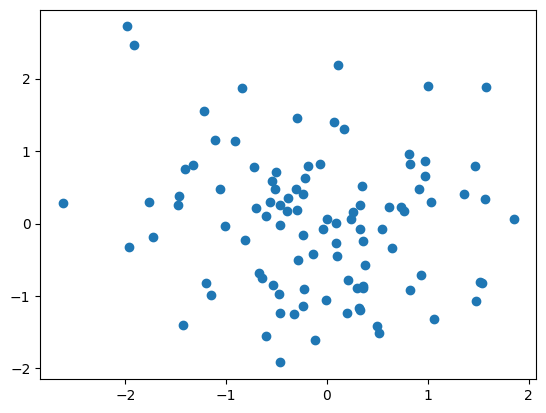

In [25]:
import matplotlib.pyplot as plt
import numpy as np

txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create scatter plot with x, y
plt.scatter(x, y)

# create scatter

In [26]:
txt = """\
# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
"""
print(pipe(txt, num_return_sequences=1)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# create some data
x = np.random.randn(100)
y = np.random.randn(100)

# create dataframe from x and y
df = pd.DataFrame(x, columns=["a", "b


### Custom Loss Function

In [29]:
from torch.nn import CrossEntropyLoss
import torch


def keytoken_weighted_loss(inputs, logits, keytoken_ids, alpha=1.0):
    # Shift so that tokens < n predict n
    shift_labels = inputs[..., 1:].contiguous()
    shift_logits = logits[..., :-1, :].contiguous()
    # Calculate per-token loss
    loss_fct = CrossEntropyLoss(reduce=False)
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    # Resize and average loss per sample
    loss_per_sample = loss.view(shift_logits.size(0), shift_logits.size(1)).mean(axis=1)
    # Calculate and scale weighting
    weights = torch.stack([(inputs == kt).float() for kt in keytoken_ids]).sum(
        axis=[0, 2]
    )
    weights = alpha * (1.0 + weights)
    # Calculate weighted average
    weighted_loss = (loss_per_sample * weights).mean()
    return weighted_loss

In [30]:
from torch.utils.data.dataloader import DataLoader

tokenized_datasets.set_format("torch")
train_dataloader = DataLoader(tokenized_datasets["train"], batch_size=32, shuffle=True)
eval_dataloader = DataLoader(tokenized_datasets["valid"], batch_size=32)

In [31]:
weight_decay = 0.1


def get_grouped_params(model, no_decay=["bias", "LayerNorm.weight"]):
    params_with_wd, params_without_wd = [], []
    for n, p in model.named_parameters():
        if any(nd in n for nd in no_decay):
            params_without_wd.append(p)
        else:
            params_with_wd.append(p)
    return [
        {"params": params_with_wd, "weight_decay": weight_decay},
        {"params": params_without_wd, "weight_decay": 0.0},
    ]

In [32]:
def evaluate():
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])

        losses.append(accelerator.gather(outputs.loss))
    loss = torch.mean(torch.cat(losses))
    try:
        perplexity = torch.exp(loss)
    except OverflowError:
        perplexity = float("inf")
    return loss.item(), perplexity.item()

In [33]:
model = GPT2LMHeadModel(config)

In [34]:
from torch.optim import AdamW

optimizer = AdamW(get_grouped_params(model), lr=5e-4)

In [37]:
from accelerate import Accelerator

accelerator = Accelerator()
# accelerator = Accelerator(fp16=True) #with cuda

model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [38]:
from transformers import get_scheduler

num_train_epochs = 1
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=1_000,
    num_training_steps=num_training_steps,
)

In [39]:
from huggingface_hub import Repository, get_full_repo_name

model_name = "codeparrot-ds-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'AshknMrd/codeparrot-ds-accelerate'

In [ ]:
evaluate()

In [ ]:
from tqdm.notebook import tqdm

gradient_accumulation_steps = 8
eval_steps = 5_000

model.train()
completed_steps = 0
for epoch in range(num_train_epochs):
    for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=num_training_steps
    ):
        logits = model(batch["input_ids"]).logits
        loss = keytoken_weighted_loss(batch["input_ids"], logits, keytoken_ids)
        if step % 100 == 0:
            accelerator.print(
                {
                    "samples": step * samples_per_step,
                    "steps": completed_steps,
                    "loss/train": loss.item() * gradient_accumulation_steps,
                }
            )
        loss = loss / gradient_accumulation_steps
        accelerator.backward(loss)
        if step % gradient_accumulation_steps == 0:
            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            completed_steps += 1
        if (step % (eval_steps * gradient_accumulation_steps)) == 0:
            eval_loss, perplexity = evaluate()
            accelerator.print({"loss/eval": eval_loss, "perplexity": perplexity})
            model.train()
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
            if accelerator.is_main_process:
                tokenizer.save_pretrained(output_dir)
                repo.push_to_hub(
                    commit_message=f"Training in progress step {step}", blocking=False
                )